In [190]:
!pip install pyautogen
!pip install textblob
!pip install networkx matplotlib
!pip install sentence-transformers faiss 
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [191]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
api_key = os.getenv("OPENAI_API_KEY")
print(f"API Key Loaded: {api_key is not None}")


API Key Loaded: True


In [192]:
from autogen import ConversableAgent

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("API Key not found! Make sure your .env file contains OPENAI_API_KEY.")

# Summary Agent
summary_agent = ConversableAgent(
    "summary_agent",
    llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": api_key}]},
    code_execution_config=False,
    function_map=None,
    human_input_mode="NEVER",
)

# Topic Agent
topic_agent = ConversableAgent(
    "topic_agent",
    llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": api_key}]},
    code_execution_config=False,
    function_map=None,
    human_input_mode="NEVER",
)

# Detail Agent
detail_agent = ConversableAgent(
    "detail_agent",
    llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": api_key}]},
    code_execution_config=False,
    function_map=None,
    human_input_mode="NEVER",
)

# Coordinator Agent
coordinator_agent = ConversableAgent(
    "coordinator_agent",
    llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": api_key}]},
    code_execution_config=False,
    function_map=None,
    human_input_mode="NEVER",
)

print("Agents initialized successfully!")


Agents initialized successfully!


In [233]:
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
import numpy as np

def load_transcript(file_path):
    """Load the conversation transcript from a text file."""
    with open(file_path, 'r') as file:
        return file.read()

def extract_topics_with_confidence(transcript, n_clusters=5):
    """
    Extract topics from the transcript with dynamic confidence scoring.
    
    Parameters:
        transcript (str): Conversation transcript.
        n_clusters (int): Number of clusters/topics to extract.

    Returns:
        topics (list): List of topics with confidence scores and excerpts.
    """
    import re
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    import numpy as np

    # Split transcript into individual statements
    lines = re.split(r"\n[M|R]:", transcript)
    cleaned_lines = [line.strip() for line in lines if line.strip()]

    # Step 1: TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
    tfidf_matrix = vectorizer.fit_transform(cleaned_lines)

    # Step 2: Clustering with KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    # Step 3: Confidence Score Calculation
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    topics = []

    for cluster_id in range(n_clusters):
        # Extract statements in this cluster
        cluster_statements = [
            cleaned_lines[i] for i in range(len(cleaned_lines)) if cluster_labels[i] == cluster_id
        ]

        # Cluster coherence: mean distance of points to cluster center
        cluster_points = tfidf_matrix[cluster_labels == cluster_id]
        cluster_center = kmeans.cluster_centers_[cluster_id]
        distances = cluster_points.dot(cluster_center).mean()

        # Dynamic confidence score based on distances and silhouette_avg
        confidence_score = round((distances / silhouette_avg) * 10, 2)

        # Topic name: top terms from cluster center
        cluster_center_reshaped = cluster_center.reshape(1, -1)
        top_terms = vectorizer.get_feature_names_out()[np.argsort(-cluster_center)[:3]]
        topic_name = f"Discussion about: {' '.join(top_terms)}"

        topics.append({
            "topic_name": topic_name,
            "confidence": confidence_score,
            "excerpts": cluster_statements
        })

    return topics


# Example Usage
file_path = "/Users/naren/Desktop/CONSUMA_AI_ASSIGNMENT/Round2-Assessment-transcript.txt"
transcript = load_transcript(file_path)
topics = extract_topics_with_confidence(transcript, n_clusters=5)

# Display the extracted topics
for topic in topics:
    print(f"Topic Name: {topic['topic_name']}")
    print(f"Confidence Score: {topic['confidence']}")
    print(f"Excerpts: {topic['excerpts'][:3]}")  # Show up to 3 sample excerpts
    print("-" * 50)




# Initialize SentenceTransformer model for embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(chunks):
    """Generate embeddings for chunks of text."""
    return np.array(embedding_model.encode(chunks))

def create_faiss_index(embeddings):
    """Create a FAISS index for fast retrieval."""
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    return index

def retrieve_relevant_chunks(query, chunks, index, top_k=3):
    """Retrieve relevant chunks based on query using FAISS index."""
    query_embedding = embedding_model.encode([query])
    distances, indices = index.search(query_embedding, top_k)
    return [chunks[i] for i in indices[0]]


Topic Name: Discussion about: ok stock time
Confidence Score: 56.26
Excerpts: ['Ok. How old are your kids?', 'Ok.', 'Ok. When do you get free time?']
--------------------------------------------------
Topic Name: Discussion about: medicines buy generic
Confidence Score: 3.51
Excerpts: ['M: Hello Mrs. Renuka. My name is Archana and we are from a market research company. Basically, our job is to meet public and know about the products they use and its services etc. There is nothing right or wrong answers, you can just tell your opinions freely and frankly.', 'Okay.', "We are recording this because it takes a lot of time to write all that you are telling. So, we just record this for our analysis purpose and the whole thing is kept confidentially. You don't have to be worried about this. Can you please give a brief introduction about yourself?"]
--------------------------------------------------
Topic Name: Discussion about: doctor medicine use
Confidence Score: 21.66
Excerpts: ['When cold

In [234]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

def map_topic_relationships(topics):
    """
    Identify relationships between topics based on semantic similarity.
    """
    if not topics:
        return {}
    
    # Extract topic excerpts
    corpus = [" ".join(topic["excerpts"]) for topic in topics]
    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(corpus)
    similarity_matrix = cosine_similarity(tfidf_matrix)

    relationships = {}
    threshold = 0.5  # Define a similarity threshold for relationships

    for i, topic in enumerate(topics):
        related_topics = []
        for j, score in enumerate(similarity_matrix[i]):
            if i != j and score > threshold:  # Avoid self-similarity
                related_topics.append(topics[j]["topic_name"])
        relationships[topic["topic_name"]] = related_topics

    return relationships


def visualize_topic_relationships(relationships):
    """
    Visualize topic relationships as a graph using networkx and matplotlib.
    """
    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.Graph()

    # Add nodes and edges
    for topic, related_topics in relationships.items():
        G.add_node(topic)
        for related_topic in related_topics:
            G.add_edge(topic, related_topic)

    # Plot the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(
        G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, font_weight="bold"
    )
    plt.title("Topic Relationships")
    plt.show()



def recursive_summarization_with_rag(transcript):
    """Perform recursive summarization with RAG and contextual compression."""
    if not transcript:
        return {
            "master_summary": "Error: Transcript is empty or invalid.",
            "topics": [],
            "detailed_topics": [],
            "relationships": {}
        }

    results = {}

    # Step 1: Chunk the Transcript
    chunks = [transcript[i:i+500] for i in range(0, len(transcript), 500)]  # Adjust chunk size based on token limits

    # Step 2: Generate Embeddings and Create Index
    print("Creating RAG index...")
    embeddings = generate_embeddings(chunks)
    index = create_faiss_index(embeddings)

    # Step 3: High-Level Summary
    print("Generating High-Level Summary...")
    try:
        relevant_chunks = retrieve_relevant_chunks("Generate a high-level summary", chunks, index)
        compressed_transcript = " ".join(relevant_chunks)
        results["master_summary"] = generate_summary(compressed_transcript)
    except Exception as e:
        print(f"Error in generating high-level summary: {e}")
        results["master_summary"] = "Error: Failed to generate master summary."

    # Step 4: Topic Extraction
    print("Extracting Topics...")
    try:
        topics = extract_topics_with_confidence(compressed_transcript, n_clusters=5)
        results["topics"] = topics
    except Exception as e:
        print(f"Error in extracting topics: {e}")
        results["topics"] = []

    # Step 5: Detailed Summaries for Topics
    print("Generating Detailed Summaries for Topics...")
    try:
        if "topics" in results and results["topics"]:
            detailed_topics = generate_detail_summaries(results["topics"])
            results["detailed_topics"] = detailed_topics
        else:
            results["detailed_topics"] = []
    except Exception as e:
        print(f"Error in generating detailed summaries: {e}")
        results["detailed_topics"] = []

    # Step 6: Map Topic Relationships
    print("Mapping Topic Relationships...")
    try:
        if "detailed_topics" in results and results["detailed_topics"]:
            relationships = map_topic_relationships(results["detailed_topics"])
            results["relationships"] = relationships
        else:
            results["relationships"] = {}
    except Exception as e:
        print(f"Error in mapping topic relationships: {e}")
        results["relationships"] = {}

    return results


In [235]:
from sklearn.metrics import silhouette_score
from textblob import TextBlob

def generate_summary(transcript):
    """Generate a high-level summary using the Summary Agent."""
    prompt = f"Summarize the following transcript into a concise overview:\n\n{transcript}"
    response = summary_agent.generate_reply(messages=[{"role": "user", "content": prompt}])
    return response

def generate_detail_summaries(topics):
    """Generate detailed summaries for each topic and analyze sentiment."""
    if not topics:
        return []

    detailed_topics = []
    for topic in topics:
        try:
            prompt = (
                f"Provide a detailed summary for the following topic:\n"
                f"Topic Name: {topic['topic_name']}\n"
                f"Excerpts:\n{' '.join(topic['excerpts'])}\n\n"
                "Break it down into subtopics if applicable."
            )
            response = detail_agent.generate_reply(messages=[{"role": "user", "content": prompt}])

            # Sentiment Analysis
            combined_excerpts = " ".join(topic["excerpts"])
            sentiment = TextBlob(combined_excerpts).sentiment

            detailed_topics.append({
                "topic_name": topic["topic_name"],
                "confidence": topic["confidence"],
                "detailed_summary": response,
                "excerpts": topic["excerpts"],
                "sentiment": {
                    "polarity": round(sentiment.polarity, 2),
                    "subjectivity": round(sentiment.subjectivity, 2)
                }
            })
        except Exception as e:
            print(f"Error summarizing topic '{topic['topic_name']}': {e}")
            detailed_topics.append({
                "topic_name": topic["topic_name"],
                "confidence": topic["confidence"],
                "detailed_summary": "Error: Failed to generate detailed summary.",
                "excerpts": topic["excerpts"],
                "sentiment": {
                    "polarity": None,
                    "subjectivity": None
                }
            })

    return detailed_topics

# Example usage
file_path = "/Users/naren/Desktop/CONSUMA_AI_ASSIGNMENT/Round2-Assessment-transcript.txt"
transcript = load_transcript(file_path)

# Extract topics
topics = extract_topics_with_confidence(transcript, n_clusters=5)

# Generate high-level summary
high_level_summary = generate_summary(transcript)

# Generate detailed summaries for topics
detailed_topics = generate_detail_summaries(topics)

# Display results
print("High-Level Summary:")
print(high_level_summary)
print("\nDetailed Topics:")
for topic in detailed_topics:
    print(f"Topic Name: {topic['topic_name']}")
    print(f"Confidence Score: {topic['confidence']}")
    print(f"Detailed Summary: {topic['detailed_summary']}")
    print("-" * 50)


High-Level Summary:
The transcript is a detailed market research interview conducted by Archana with Mrs. Renuka, a housewife from Hyderabad. Renuka introduces herself and shares that she takes care of her household, which includes her husband, two children, and elderly parents. She begins her day at 6 AM, managing household chores and caring for her family. In her free time, she enjoys watching YouTube videos, particularly cooking and temple-related content, as well as OTT platforms like Amazon and Netflix.

Renuka discusses her role as the primary decision-maker regarding household matters, including food, groceries, and medical care for her family. She describes her neighborhood in Tilaknagar as comfortable with accessible grocery shopping and medical facilities. Health consciousness is important to her, especially concerning her parents, who face health issues like diabetes and high blood pressure. She rates her health consciousness as an 8 out of 10 and follows a careful managemen

In [236]:
def recursive_summarization(transcript):
    """Perform recursive summarization using multiple agents."""
    results = {}

    # Step 1: High-Level Summary
    print("Generating High-Level Summary...")
    try:
        high_level_summary = generate_summary(transcript)
        results["master_summary"] = high_level_summary
    except Exception as e:
        print(f"Error in generating high-level summary: {e}")
        results["master_summary"] = "Failed to generate master summary"

    # Step 2: Topic Extraction
    print("Extracting Topics...")
    try:
        topics = extract_topics_with_confidence(transcript, n_clusters=5)
        results["topics"] = topics
    except Exception as e:
        print(f"Error in extracting topics: {e}")
        results["topics"] = []

    # Step 3: Detailed Summaries for Topics
    print("Generating Detailed Summaries for Topics...")
    try:
        if "topics" in results and results["topics"]:
            detailed_topics = generate_detail_summaries(results["topics"])
            results["detailed_topics"] = detailed_topics
        else:
            results["detailed_topics"] = []
    except Exception as e:
        print(f"Error in generating detailed summaries: {e}")
        results["detailed_topics"] = []

    # Step 4: Map Topic Relationships
    print("Mapping Topic Relationships...")
    try:
        if "detailed_topics" in results and results["detailed_topics"]:
            relationships = map_topic_relationships(results["detailed_topics"])
            results["relationships"] = relationships
        else:
            results["relationships"] = {}
    except Exception as e:
        print(f"Error in mapping topic relationships: {e}")
        results["relationships"] = {}

    # Final Output
    return results


In [237]:
def create_detailed_analysis(topic):
    """
    Generate a comprehensive explanation for a given topic using the Detail Agent.
    """
    query = f"Elaborate on the following topic in detail, providing relevant insights and explanations:\n\n{topic}"
    
    # Using detail_agent to generate a reply
    result = detail_agent.generate_reply(messages=[{"role": "user", "content": query}])
    
    # Return the processed result
    return result.strip() if result else "Failed to generate a detailed explanation."


In [238]:
def execute_analysis_pipeline(transcript):
    """
    Execute the analysis pipeline by orchestrating different agents.
    """
    # Step 1: Generate a concise high-level summary
    print("Generating a high-level summary...")
    master_summary = generate_summary(transcript)
    print("Master Summary Generated:\n", master_summary)
    
    # Step 2: Identify and extract key topics from the summary
    print("\nIdentifying key topics...")
    extracted_topics = identify_topics_and_explain(master_summary)
    print("Extracted Topics:\n", extracted_topics)
    
    # Step 3: Create detailed analyses for each identified topic
    topic_details = {}
    topic_list = extracted_topics.split("\n")  # Assuming topics are newline-separated
    print("\nGenerating detailed analyses for each topic...")
    for topic in topic_list:
        clean_topic = topic.strip()
        if clean_topic:  # Ensure the topic is not empty
            detailed_analysis = create_detailed_analysis(clean_topic)
            topic_details[clean_topic] = detailed_analysis
            print(f"\nDetailed Analysis for Topic '{clean_topic}':\n", detailed_analysis)

    # Consolidate and return the results
    final_results = {
        "master_summary": master_summary,
        "extracted_topics": extracted_topics,
        "topic_details": topic_details,
    }
    return final_results


In [239]:




import json


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans



In [240]:



# Load pre-trained Sentence Transformer model for semantic embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight and efficient

In [241]:
def save_results_as_json(summary, topics, detailed_summaries):
    """
    Save the analysis results to a JSON file.
    """
    results = {
        "summary": summary,
        "topics": topics,
        "detailed_summaries": detailed_summaries
    }
    with open("analysis_results.json", "w") as json_file:
        json.dump(results, json_file, indent=4)
    print("\n[INFO] Results have been saved to 'analysis_results.json'.")

In [242]:
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from nltk.corpus import stopwords as nltk_stop_words

# Define combined stop words set
custom_stop_words = set(sklearn_stop_words).union(set(nltk_stop_words.words('english')))

def preprocess(text, stop_words=custom_stop_words):
    """
    Tokenizes and preprocesses the input text, removing stopwords and short tokens.
    """
    result = []
    for token in simple_preprocess(text, deacc=True):  # deacc=True removes accents
        if token not in stop_words and len(token) > 3:
            result.append(token)
    return result

def get_cleaned_topic_name(sentences, stop_words=custom_stop_words):
    """
    Cleans and selects the best topic name from a list of sentences.
    """
    cleaned_sentences = [" ".join(preprocess(sentence, stop_words)) for sentence in sentences]
    meaningful_sentences = [s for s in cleaned_sentences if len(s.split()) > 2]  # Keep only meaningful sentences
    return meaningful_sentences[0] if meaningful_sentences else "Miscellaneous Topic"


In [243]:
def main():
    """
    Main function to coordinate the workflow.
    """
    print("MULTI-AGENT ANALYSIS WORKFLOW")
    print("[1] Generate High-Level Summary")
    print("[2] Extract Topics with Confidence Scores")
    print("[3] Generate Detailed Summaries for Topics and Visualize Relationships")
    print("[4] Exit and Save Results")

    transcript_path = "Round2-Assessment-transcript.txt" 
    transcript = None
    summary = None
    topics = None
    detailed_summaries = {}
    relationships = {}

    try:
        # Load the transcript from the text file
        with open(transcript_path, "r") as file:
            transcript = file.read()
        print("\n[INFO] Transcript loaded successfully!")
    except Exception as e:
        print(f"\n[ERROR] Failed to load transcript: {e}")
        return

    while True:
        try:
            # Prompt user for a choice
            choice = int(input("\nSelect an option (1-4): "))
        except ValueError:
            print("\n[WARNING] Invalid input. Please select a valid option (1-4).")
            continue

        if choice == 1:
            if not transcript:
                print("\n[ERROR] Transcript not available.")
                continue
            summary = generate_summary(transcript)
            print("\n>>> Generated High-Level Summary <<<")
            print(summary)

        elif choice == 2:
            if not transcript:
                print("\n[ERROR] Transcript not available.")
                continue
            print("\n>>> Extracting Topics <<<")
            topics = extract_topics_with_confidence(transcript, n_clusters=5)
            for i, topic in enumerate(topics, 1):
                avg_confidence = topic["confidence"]
                print(f"Topic {i}: {topic['topic_name']} | Avg. Confidence: {avg_confidence:.2f}")
                print("-" * 50)

        elif choice == 3:
            if not topics:
                print("\n[ERROR] Please extract topics first (Option 2).")
                continue
            print("\n>>> Generating Detailed Summaries and Mapping Relationships <<<")
            detailed_topics = generate_detail_summaries(topics)
            relationships = map_topic_relationships(detailed_topics)

            # Display Detailed Summaries
            for i, topic in enumerate(detailed_topics, 1):
                print(f"\nDetailed Summary for Topic {i}: {topic['topic_name']}")
                print(f"Confidence Score: {topic['confidence']:.2f} (higher is better)")
                print(f"Sentiment: Polarity={topic['sentiment']['polarity']}, Subjectivity={topic['sentiment']['subjectivity']}")
                print(f"Detailed Summary: {topic['detailed_summary']}")
                print("-" * 50)

            # Visualize Relationships
            print("\n>>> Visualizing Topic Relationships <<<")
            if relationships:
                visualize_topic_relationships(relationships)
            else:
                print("\n[INFO] No topic relationships to visualize.")

        elif choice == 4:
            print("\n[INFO] Thank you for using the analysis workflow!")
            break

        else:
            print("\n[WARNING] Invalid choice. Please select a valid option (1-4).")


MULTI-AGENT ANALYSIS WORKFLOW
[1] Generate High-Level Summary
[2] Extract Topics with Confidence Scores
[3] Generate Detailed Summaries for Topics and Visualize Relationships
[4] Exit and Save Results

[INFO] Transcript loaded successfully!



Select an option (1-4):  1



>>> Generated High-Level Summary <<<
The transcript is a detailed market research interview conducted by Archana with Mrs. Renuka, a housewife from Hyderabad. Renuka introduces herself and shares that she takes care of her household, which includes her husband, two children, and elderly parents. She begins her day at 6 AM, managing household chores and caring for her family. In her free time, she enjoys watching YouTube videos, particularly cooking and temple-related content, as well as OTT platforms like Amazon and Netflix.

Renuka discusses her role as the primary decision-maker regarding household matters, including food, groceries, and medical care for her family. She describes her neighborhood in Tilaknagar as comfortable with accessible grocery shopping and medical facilities. Health consciousness is important to her, especially concerning her parents, who face health issues like diabetes and high blood pressure. She rates her health consciousness as an 8 out of 10 and follows a


Select an option (1-4):  2



>>> Extracting Topics <<<
Topic 1: Discussion about: ok stock time | Avg. Confidence: 56.26
--------------------------------------------------
Topic 2: Discussion about: medicines buy generic | Avg. Confidence: 3.51
--------------------------------------------------
Topic 3: Discussion about: doctor medicine use | Avg. Confidence: 21.66
--------------------------------------------------
Topic 4: Discussion about: yes madam heard | Avg. Confidence: 127.33
--------------------------------------------------
Topic 5: Discussion about: savings apollo good | Avg. Confidence: 26.81
--------------------------------------------------



Select an option (1-4):  3



>>> Generating Detailed Summaries and Mapping Relationships <<<

Detailed Summary for Topic 1: Discussion about: ok stock time
Confidence Score: 56.26 (higher is better)
Sentiment: Polarity=0.2, Subjectivity=0.44
Detailed Summary: ### Summary of the Discussion on "Ok Stock Time"

The conversation appears to revolve around various topics pertaining to personal life, health management, and stockpiling medications. Below is a detailed breakdown of the main subtopics addressed in the discussion:

#### 1. **Family and Daily Life**
   - **Children's Ages**: The discussion opens with a casual inquiry about the age of the interlocutor's children, indicating a friendly approach and personal interest in family dynamics.
   - **Free Time and Interests**: The conversation delves into the individual’s free time, exploring activities undertaken during these periods, with specific emphasis on television viewing preferences. Queries include:
     - What do you watch on TV or YouTube?
     - Preferenc

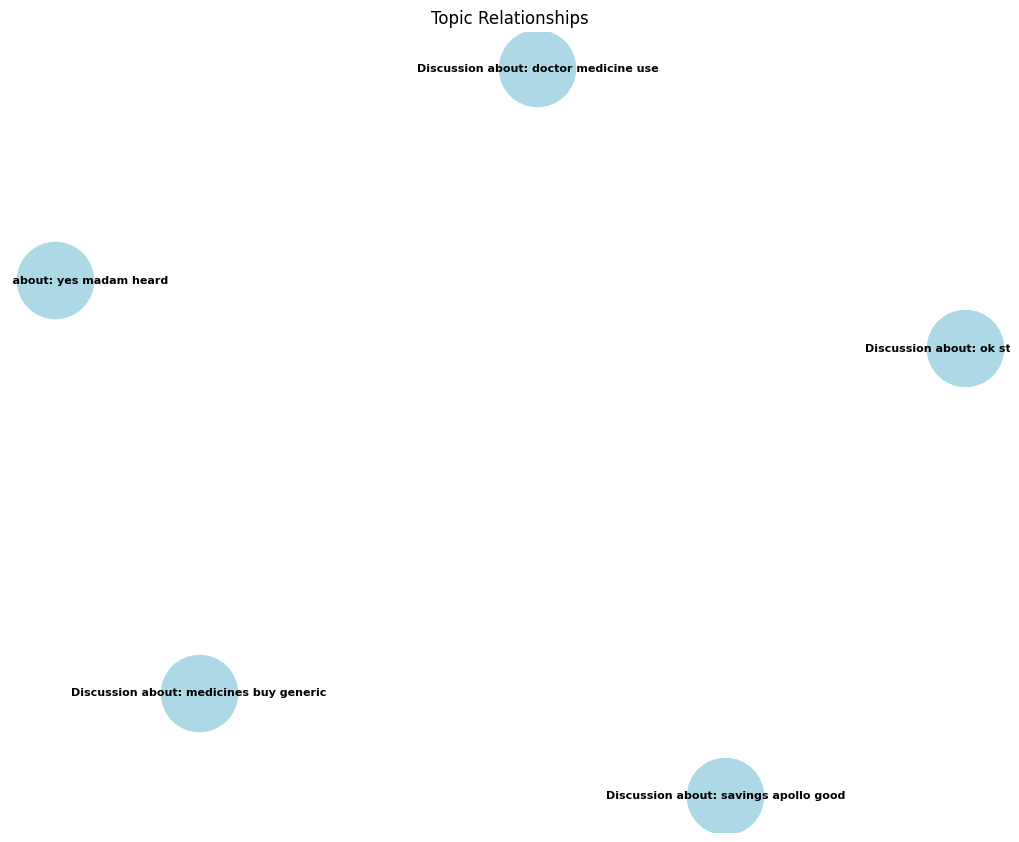


Select an option (1-4):  4



[INFO] Thank you for using the analysis workflow!


In [244]:
if __name__ == "__main__":
    main()

Creating RAG index...
Creating RAG index...
Generating High-Level Summary...
Extracting Topics...
Generating Detailed Summaries for Topics...
Mapping Topic Relationships...

Master Summary:
In the transcript, a market researcher named Archana interviews a housewife named Renuka to gather insights about her opinions on pharmaceutical products. The main focus is on increasing awareness of generic medications, emphasizing their same quality but lower prices, which offer smart savings for consumers. Renuka appreciates this message but suggests that the information about generics should be more prominently displayed, similar to the branding of Apollo's generics. She expresses no negative feedback on the information provided. Renuka introduces herself as a housewife with two children and elderly parents living with her. The conversation also touches briefly on her daily responsibilities as a housewife.

Detailed Topics:
Topic Name: Discussion about: mean liked yes
Confidence Score: 12.9 (hig

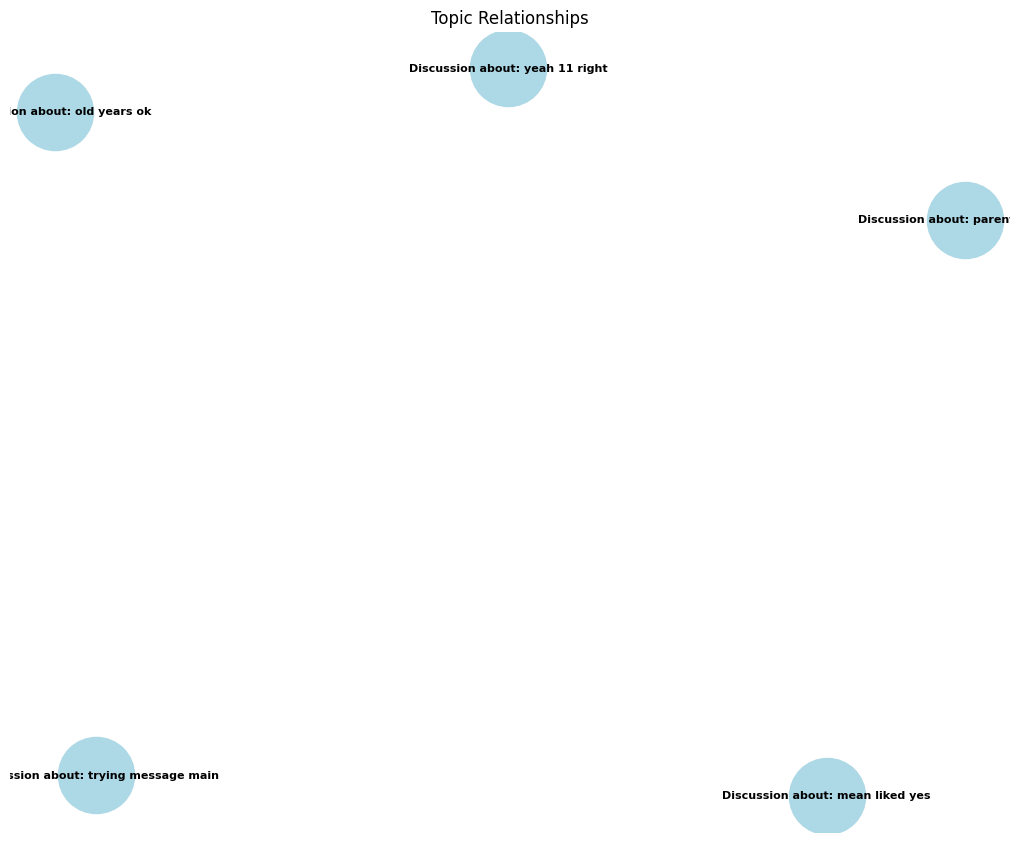

In [245]:
file_path = "/Users/naren/Desktop/CONSUMA_AI_ASSIGNMENT/Round2-Assessment-transcript.txt"
transcript = load_transcript(file_path)

# Run analysis
print("Creating RAG index...")
analysis_results = recursive_summarization_with_rag(transcript)

# Display results
print("\nMaster Summary:")
print(analysis_results["master_summary"])
print("\nDetailed Topics:")
for topic in analysis_results.get("detailed_topics", []):
    print(f"Topic Name: {topic['topic_name']}")
    print(f"Confidence Score: {topic['confidence']} (higher is better)")
    print(f"Sentiment: Polarity={topic['sentiment']['polarity']}, Subjectivity={topic['sentiment']['subjectivity']}")
    print(f"Detailed Summary: {topic['detailed_summary']}")
    print("-" * 50)

# Relationships and visualization
print("\nTopic Relationships:")
if analysis_results.get("relationships"):
    for topic, related_topics in analysis_results["relationships"].items():
        print(f"{topic} -> {related_topics}")
    print("\nVisualizing Topic Relationships...")
    visualize_topic_relationships(analysis_results["relationships"])
else:
    print("No relationships found to visualize.")
